In this notebook we process a large part of the glaciers in the Alps. The image is chosen in such a way that the
most important glaciers in France/Austria/Switzerland/Italy are covered.

In [5]:
# Import script to embed geolocation.
from IPython.display import HTML
import datetime

import sys
sys.path.extend(['/Users/gertmulder/software/rippl_main'])

from rippl.orbit_geometry.read_write_shapes import ReadWriteShapes
from rippl.SAR_sensors.sentinel.sentinel_download import DownloadSentinel
from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

glacier_shape = [[11.260986328125, 46.84516443029276],
            [12.095947265625, 46.803819640791545],
            [13.073730468750002, 46.830133640447386],
            [13.5955810546875, 46.9465122958623],
            [13.403320312499998, 47.204642388766935],
            [10.607299804687523, 47.247542522267985],
            [9.6240234375, 46.927758623434435],
            [8.827514648437523, 47.00835281693702],
            [7.772827148437526, 46.63246472462745],
            [6.701660156249999, 46.118941506107056],
            [6.597290039062523, 45.673563046842496],
            [6.0150146484375, 45.263288531496855],
            [6.0479736328125, 44.762336674810996],
            [6.43798828125, 44.793530904744046],
            [6.6796875, 44.98034238084973],
            [7.2894287109375,45.28261705751738],
            [7.3663330078125, 45.4947963896697],
            [8.052978515625, 45.84028105450088],
            [8.316650390625, 46.20264638061017],
            [8.9208984375, 46.244451065485066],
            [9.563598632812523, 46.1246527020117],
            [10.2557373046875, 46.1912395780416],
            [10.838012695312523, 46.50406399740095],
            [11.260986328125, 46.84516443029276]]
study_area = ReadWriteShapes()
study_area(glacier_shape)

geojson = study_area.shape

# Try to do the same by creating a shapefile with QGIS, geojson online or a .kml file in google earth.
# study_area.read_kml(kml_path)
# study_area.read_geo_json(geojson_path)
# study_area.read_shapefile(shapefile_path)

The next step in the processing is selection of the right track, as the Sentinel-1 satellite will cover the area on both
ascending and descending tracks. However, to do so, we will have to define the start and end date of our data search, 
because the satellite is not always acquiring data. 
Next search will give a small oversight of the available tracks during our period of interest. In our case we will 
search one week before and one week after the earthquake.

Watch out with extending the search window, this can result in a lot of images. Note that every downloaded file will take approximately 4GB of disk space!

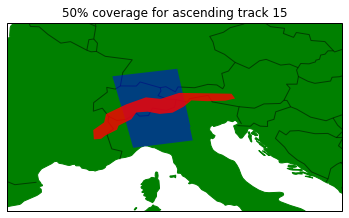

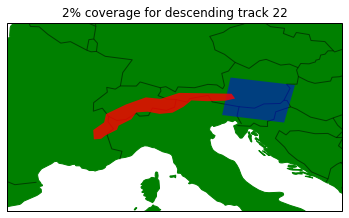

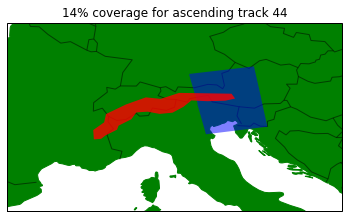

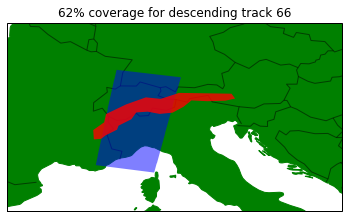

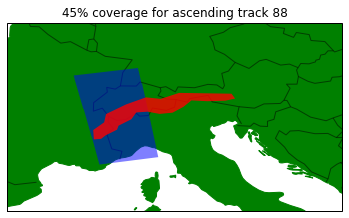

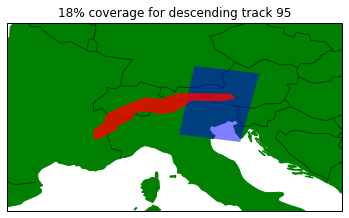

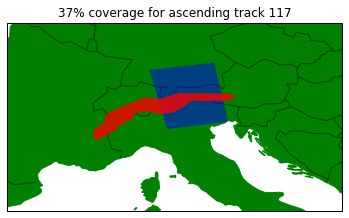

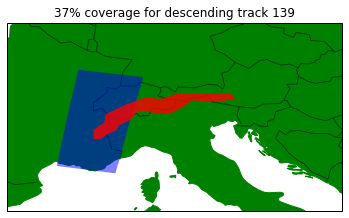

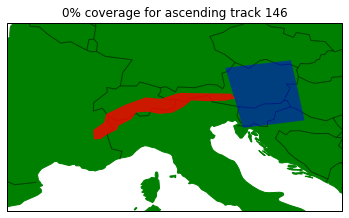

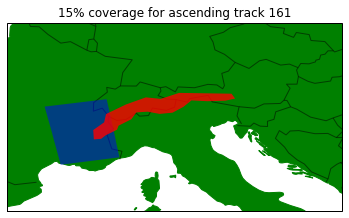

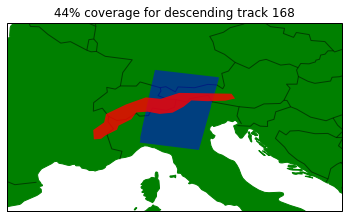

Summary statistics for Sentinel-1 search:
Stack for ascending track 15 contains 28 images with 50% coverage of area of interest
Stack for descending track 22 contains 30 images with 2% coverage of area of interest
Stack for ascending track 44 contains 30 images with 14% coverage of area of interest
Stack for descending track 66 contains 30 images with 62% coverage of area of interest
Stack for ascending track 88 contains 29 images with 45% coverage of area of interest
Stack for descending track 95 contains 30 images with 18% coverage of area of interest
Stack for ascending track 117 contains 31 images with 37% coverage of area of interest
Stack for descending track 139 contains 31 images with 37% coverage of area of interest
Stack for ascending track 146 contains 31 images with 0% coverage of area of interest
Stack for ascending track 161 contains 30 images with 15% coverage of area of interest
Stack for descending track 168 contains 30 images with 44% coverage of area of interest

Ful

In [6]:
# First we search using a time window

# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = 'VV'

# First we check using a time window
start_date = datetime.datetime(year=2018, month=4, day=1)
end_date = datetime.datetime(year=2018, month=10, day=1)

find_track = DownloadSentinel(start_date=start_date, end_date=end_date, shape=study_area.shape, sensor_mode=mode,
                              polarisation=polarisation)
find_track.sentinel_search_ASF()
find_track.summarize_search_results(plot_cartopy=True, buffer=2)


In [ ]:
# Track and data type of Sentinel data
mode = 'IW'
product_type = 'SLC'
polarisation = 'VV'

from rippl.processing_templates.general_sentinel_1 import GeneralPipelines

# Create the list of the 4 different stacks.
track_no = 66
stack_name = 'glaciers_Alps'
# For every track we have to select a master date. This is based on the search results earlier.
# Choose the date with the lowest coverage to create an image with only the overlapping parts.
master_date = datetime.datetime(year=2018, month=8, day=20)

# Stack test
start_date = datetime.datetime(year=2018, month=8, day=19)
end_date = datetime.datetime(year=2018, month=8, day=30)

# Number of processes for parallel processing. Make sure that for every process at least 2GB of RAM is available
no_processes = 4

s1_processing = GeneralPipelines(processes=no_processes)
s1_processing.download_sentinel_data(start_date=start_date, end_date=end_date, track=track_no,
                                           polarisation=polarisation, shapefile=study_area.shape, data=True, source='ASF')
s1_processing.create_sentinel_stack(start_date=start_date, end_date=end_date, master_date=master_date, cores=no_processes,
                                          track=track_no,stack_name=stack_name, polarisation=polarisation,
                                          shapefile=study_area.shape, mode=mode, product_type=product_type)

# Finally load the stack itself. If you want to skip the download step later, run this line before other steps!
s1_processing.read_stack(start_date=start_date, end_date=end_date, stack_name=stack_name)

wget -c --http-user=gertmulder --http-password=Radar2016 --no-check-certificate "https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_SLC__1SDV_20180826T053542_20180826T053609_023413_028C38_00CD.zip" -O /Users/gertmulder/SAR_processing/radar_database/Sentinel-1/s1_dsc_t66/IW_SLC__1SDV_VVVH/20180826/S1A_IW_SLC__1SDV_20180826T053542_20180826T053609_023413_028C38_00CD.zip


To define the location of the radar pixels on the ground we need the terrain elevation. Although it is possible to 
derive terrain elevation from InSAR data, our used Sentinel-1 dataset is not suitable for this purpose. Therefore, we
download data from an external source to create a digital elevation model (DEM). In our case we use SRTM data. 

However, to find the elevation of the SAR data grid, we have to resample the data to the radar grid first to make it
usable. This is done in the next steps.

In [3]:
# Some basic settings for DEM creation.
dem_buffer = 0.1        # Buffer around radar image where DEM data is downloaded
dem_rounding = 0.1      # Rounding of DEM size in degrees
dem_type = 'SRTM3'      # DEM type of data we download (SRTM1, SRTM3 and TanDEM-X are supported)

# Define both the coordinate system of the full radar image and imported DEM
s1_processing.create_radar_coordinates()
s1_processing.create_dem_coordinates(dem_type=dem_type)

# Download external DEM
s1_processing.download_external_dem(buffer=dem_buffer, rounding=dem_rounding, n_processes=no_processes)

Using the obtained elevation model the exact location of the radar pixels in cartesian (X,Y,Z) and geographic (Lat/Lon)
can be derived. This is only done for the master or reference image. This process is referred to as geocoding.

In [4]:
# Geocoding of image
s1_processing.geocoding()

Processing pipeline block 1 out of 1
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Skipping processing. Process already finished
Processing pipeline block 1 out of 1
Start processing dem block 1 out of 12 [2 of total 168] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505/slice_505_swath_2
Processing image region from lines 739 > 861 and pixels 1 > 2

The information from the geocoding can directly be used to find the location of the master grid pixels in the slave
grid images. This process is called coregistration. Because the orbits are not exactly the same with every satellite 
overpass but differ hundreds to a few thousand meters every overpass, the grids are slightly shifted with respect to 
each other. These shift are referred to as the spatial baseline of the images. To correctly overlay the master and slave
images the software coregisters and resamples to the master grid.

To do so the following steps are done:
1. Coregistration of slave to master image
2. Deramping the doppler effects due to TOPs mode of Sentinel-1 satellite
3. Resampling of slave image
4. Reramping resampled slave image.

Due to the different orbits of the master and slave image, the phase of the radar signal is also shifted. We do not 
know the exact shift of the two image, but using the geometry of the two images we can estimate the shift of the phase
between different pixels. Often this shift is split in two contributions:
1. The flat earth phase. This phase is the shift in the case the earth was a perfect ellipsoid
2. The topographic phase. This is the phase shift due to the topography on the ground.
In our processing these two corrections are done in one go.

In [5]:
# Next step applies resampling and phase correction in one step.
# Polarisation
s1_processing.geometric_coregistration_resampling(polarisation=polarisation, output_phase_correction=True)

Processing pipeline block 1 out of 2
Start processing geometric_coregistration block 1 out of 8 [2 of total 360] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180423/slice_500_swath_2
Processing image region from lines 821 > 1025 and pixels 1 > 24456 with size 205 x 24456 from total image size 1454 x 24456
Start processing geometric_coregistration block 1 out of 6 [1 of total 360] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180423/slice_506_swath_1
Processing image region from lines 981 > 1225 and pixels 1 > 20458 with size 245 x 20458 from total image size 1454 x 20458
Start processing geometric_coregistration block 1 out of 8 [0 of total 360] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505/slice_502_swath_2
Processing image region from lines 616 > 820 and pixels 1 > 24456 with size 205 x 24456 from total image size 1454 x 24456
Start p

Before we create an interferogram the different bursts are first mosaicked. This can only be done after resampling as
it is influenced by the phase ramps in TOPs mode of Sentinel-1. 

The independent SAR grids can now be visualized using the amplitude of the resampled data. In our case these are 
written as .tiff files for a georeferenced grid of the region. The data can be visualized using QGIS. The amplitude power
is given in dB. 

In [6]:
# Resolution of output georeferenced grid
dlat = 0.001
dlon = 0.001

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(coor_type='geographic', dlat=dlat, dlon=dlon)
s1_processing.prepare_multilooking_grid(polarisation)
s1_processing.create_calibrated_amplitude_multilooked(polarisation)
s1_processing.create_output_tiffs_amplitude()

Finished concatenation crop of /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing pipeline block 1 out of 1
Start processing reproject block 1 out of 108 [1 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 11301 > 11413 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [0 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 5312 > 5424 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [3 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 1131 > 1243 and pixels 1 > 44435 with size 113 x 44435

We can do the same thing using a projected grid with distances in meters. In this case we use the oblique mercator
projection. This projection can be configured in such a way that the grid follows the orbit of the satellite, which has
the advantage that the final product will be smaller, has less empty spaces and respects the satellite azimuth and
range directions.

In [7]:
# Resolution of output georeferenced grid
dy = 100
dx = 100

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(standard_type='oblique_mercator', dx=dx, dy=dy, buffer=0, rounding=0)
s1_processing.prepare_multilooking_grid(polarisation)
s1_processing.create_calibrated_amplitude_multilooked(polarisation)
s1_processing.create_output_tiffs_amplitude()

Concatenated dataset already exists. If you want to overwrite set overwrite to True
Processing pipeline block 1 out of 1
Start processing reproject block 1 out of 108 [3 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 7120 > 7232 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [0 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 1696 > 1808 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [2 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 3843 > 3955 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start pro

After moasicing we can create the interferogram between the different images. This image is also multilooked and 
outputted as a .tiff file. This can also be viewed in QGIS. Because the phase shift between different pixels is often 
larger than two pi radians or a wavelength (56 mm for C-band), this image will show fringes going from -pi to pi and 
starting at -pi again. 
Using the same multilooking grid also a coherence grid is created, which indicates the quality of the obtained phases.

In [8]:
s1_processing.create_ifg_network(temporal_baseline=30)
s1_processing.create_interferogram_multilooked(polarisation)
s1_processing.create_coherence_multilooked(polarisation)

# Create output geotiffs
s1_processing.create_output_tiffs_coherence_ifg()

# Create lat/lon/incidence angle/DEM for multilooked grid.
s1_processing.create_geometry_mulitlooked()
s1_processing.create_output_tiffs_geometry()


Processing pipeline block 1 out of 1
Start processing interferogram block 1 out of 1 [0 of total 1] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180423_20180505
Processing image region from lines 1 > 1716 and pixels 1 > 1802 with size 1716 x 1802 from total image size 1716 x 1802
Processing 0 out of 54
Processing 1 out of 54
Processing 2 out of 54
Processing 3 out of 54
Processing 4 out of 54
Processing 5 out of 54
Processing 6 out of 54
Processing 7 out of 54
Processing 8 out of 54
Processing 9 out of 54
Processing 10 out of 54
Processing 11 out of 54
Processing 12 out of 54
Processing 13 out of 54
Processing 14 out of 54
Processing 15 out of 54
Processing 16 out of 54
Processing 17 out of 54
Processing 18 out of 54
Processing 19 out of 54
Processing 20 out of 54
Processing 21 out of 54
Processing 22 out of 54
Processing 23 out of 54
Processing 24 out of 54
Processing 25 out of 54
Processing 26 out of 54
Processing 27 out of 54
Processi

/Users/gertmulder/software/rippl_main/rippl/meta_data/image_data.py:424: RuntimeWarning: divide by zero encountered in log
  data.GetRasterBand(1).WriteArray(np.log(np.abs(self.memory['data'])))


To go to absolute differences the data is therefore unwrapped. The result of this is given in the unwrapped geotiff.
For the unwrapping we use the program snaphu. With a resolution of 100 meters the unwrapping can take quite some time.
If you want to speed up the unwrapping you could go for larger grid cells.

In [9]:
# To do unwrapping we use the program
# You can do the unwrapping if you change resolution of the image though.
dy = 150
dx = 150

# The actual creation of the calibrated amplitude images
s1_processing.create_ml_coordinates(standard_type='oblique_mercator', dx=dx, dy=dy, buffer=0, rounding=0)
s1_processing.prepare_multilooking_grid(polarisation)

s1_processing.create_interferogram_multilooked(polarisation)
s1_processing.create_coherence_multilooked(polarisation)

# Create output geotiffs
s1_processing.create_output_tiffs_coherence_ifg()

s1_processing.create_unwrapped_images(polarisation)
s1_processing.create_output_tiffs_unwrap()

Concatenated dataset already exists. If you want to overwrite set overwrite to True
Processing pipeline block 1 out of 1
Start processing reproject block 1 out of 108 [0 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 4973 > 5085 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [3 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Processing image region from lines 679 > 791 and pixels 1 > 44435 with size 113 x 44435 from total image size 12186 x 44435
Start processing reproject block 1 out of 108 [1 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_may_2018_descending/20180505
Start processing reproject block 1 out of 108 [2 of total 108] for /Users/gertmulder/SAR_processing/radar_datastacks/Sentinel-1/Hawaii_ma

/Users/gertmulder/software/rippl_main/rippl/meta_data/image_data.py:424: RuntimeWarning: divide by zero encountered in log
  data.GetRasterBand(1).WriteArray(np.log(np.abs(self.memory['data'])))


This finishes the tutorial! In QGIS you can visualize the results of your processing.